In [1]:
import sys
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt #data visualization
#OpenCV blurs an image by applying what's called a Kernel.
#Kernel: A simple 2d matrix used in convolution or Convolution Matrix or a mask used to blur, sharpen and edge detect an image
#A Kernel tells you how to change the value of any given pixel by combining it with different amounts of the neighboring pixels. 
#The kernel is applied to every pixel in the image one-by-one to produce the final image (this operation known as a convolution).

In [2]:
def showotp(iimg,oimg,ootp):
        plt.subplot(121),plt.imshow(iimg, cmap = 'gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(oimg, cmap = 'gray')
        plt.title(ootp), plt.xticks([]), plt.yticks([])
        return plt.show()

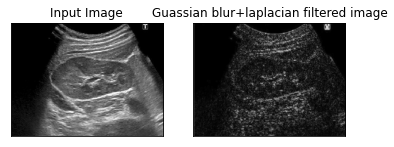

In [3]:
#Edge detection is an image processing technique for finding the boundaries of objects within images
#ksize or kernel size -> it is the size of grid that we want to blur
img1 = cv.imread(r'C:\Users\GOWTHAM\machine learning\The-original-ultrasound-kidney-image.png',cv.IMREAD_COLOR) #imread ->load image , imread_color->load color image in rgb  
src = cv.GaussianBlur(img1, (3, 3), 0) #alg that reduce noise and high frewuency components ie details
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY) #to convert a given image from one color space to another color space
dest = cv.Laplacian(src_gray, cv.CV_16S, ksize=3) #derivative operator which is used to find edges in an image
abs_dest = cv.convertScaleAbs(dest) #scales, computes absolute values and converts the result to 8-bit.
showotp(img1,abs_dest,"Guassian blur+laplacian filtered image")

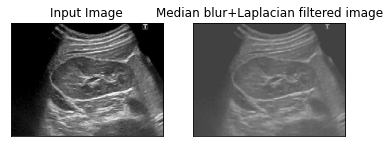

In [4]:
img = cv.imread(r'C:\Users\GOWTHAM\machine learning\The-original-ultrasound-kidney-image.png',0)
dst = cv.medianBlur(img, 5)#the central element of the image is replaced by the median of all the pixels in the kernel area
lap = cv.Laplacian(dst,cv.CV_64F)
sharp = dst - 0.3*lap
showotp(img,sharp,"Median blur+Laplacian filtered image")
img = cv.imread(r'C:\Users\GOWTHAM\machine learning\The-original-ultrasound-kidney-image.png',0)

In [5]:
#gabor filter
'''syntax for gabor kernel : 
            cv.getGaborKernel(	ksize, sigma, theta, lambd, gamma[, psi[, ktype]]	) ->	retval
Parameters:
ksize	Size of the filter returned.
sigma	Standard deviation of the gaussian envelope.
theta	Orientation of the normal to the parallel stripes of a Gabor function.
lambd	Wavelength of the sinusoidal factor.
gamma	Spatial aspect ratio.
psi	Phase offset.
ktype	Type of filter coefficients. It can be CV_32F or CV_64F'''
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 32): #0.0,0.09817477042468103,0.19634954084936207,1.4726215563702154,3.8288160465625602,3.9269908169872414,4.025165587411922,4.123340357836604
        params = {'ksize': (ksize, ksize), 'sigma': 2.5, 'theta': theta, 'lambd': 15.0,
        'gamma': 0.02, 'psi': 0, 'ktype': cv.CV_32F} #cv_32f is float value
        kern = cv.getGaborKernel(**params) #technique for improving image edge detection **for unpacking dictionary
        kern /= 1.5*kern.sum()
        filters.append((kern, params))
    return(filters)

In [6]:
#returns an array of different processed pixel values
def process(img, filters):
    accum = np.zeros_like(img) #retturns an array of zeros with the same shape and type as a given array
    for kern, params in filters:
        fimg = cv.filter2D(img, cv.CV_8UC3, kern) #combines a image with the kernel and returns a blur image
        np.maximum(accum, fimg, accum) #return an array with elements of maximum of two arrays
    return accum

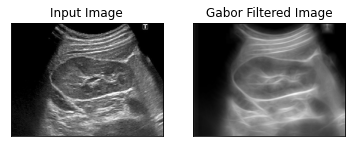

In [7]:
#output of gabor filter
filters = build_filters()
p = process(img, filters)
showotp(img,p,"Gabor Filtered Image")

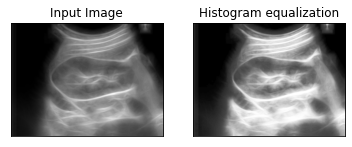

In [8]:
#Histogram equalization Output
#Histogram equalization is a method in image processing used for contrast(brightness) adjustment using the image’s histogram.
img = cv.imread(r'C:\Users\GOWTHAM\machine learning\The-original-ultrasound-kidney-image.png',0)
filters = build_filters()
p = process(img, filters)
equ = cv.equalizeHist(p)# returns an image with high contrast
showotp(p,equ,"Histogram equalization")


In [9]:
s = r'C:\Users\GOWTHAM\machine learning'
image_no = '\The-original-ultrasound-kidney-image.png'
s = s + image_no
img = cv.imread(s,0)

In [10]:
def Histeq(img):
    equ = cv.equalizeHist(img)
    return equ

In [11]:
def GaborFilter(img):
    filters = build_filters()
    p = process(img, filters)
    return p

In [12]:
def Watershed(img):
    ret, thresh = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.23*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    img2 = cv.imread(s,1)
    markers = cv.watershed(img2,markers)
    img2[markers == -1] = [255,0,0]
    return img2


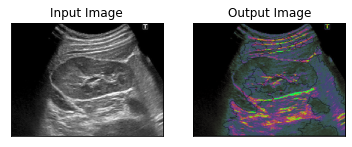

In [13]:
img3 = GaborFilter(img)
img3 = Histeq(img3)
img3 = Watershed(img)
im1 = cv.cvtColor(img3,cv.COLOR_HSV2RGB)
showotp(img,im1,"Output Image")